# How to work with ERA5 Essential Climate Variables on Earth Data Hub
### Climatological analysis of temperature in Germany

***
This notebook will provide you guidance on how to access and use the `ecv-for-climate-change-1979-2023.zarr` datset on Earth Data Hub.

The first goal is to compute the 2 metre temperature anomaly in Winter 2022 over Central Europe.

The second goal is show the winter anomaly trend, for the available time period, by averaging the anomaly over the selected area.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine data.earthdatahub.com
#   login {your_username}
#   password {your_password}

ds = xr.open_dataset(
    "https://data.earthdatahub.com/hedp/era5/ecv-for-climate-change-1979-2023.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
).astype("float32")
ds

<xarray.Dataset>
Dimensions:              (time: 537, latitude: 721, longitude: 1440)
Coordinates:
    depthBelowLandLayer  float64 ...
  * latitude             (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1978-12-31T18:00:00 ... 2023-0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(537,), meta=np.ndarray>
Data variables:
    swvl1                (time, latitude, longitude) float32 dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    t2m                  (time, latitude, longitude) float32 dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    tp                   (time, latitude, longitude) float32 dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-10-15T14:36 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: central Europe winter 2022 anomaly

### 1. Data selection

First, we select the 2 metre temperature anomaly from the ECV dataset. Then, we perform a geographical selection corresponding to the central Europe area. This greatly reduces the amount of data that will be downloaded from EDH.

In [2]:
t2m_anomaly = ds.t2m
t2m_anomaly_central_europe = t2m_anomaly.sel(**{"latitude": slice(55, 45), "longitude": slice(2, 24)})
t2m_anomaly_central_europe

<xarray.DataArray 't2m' (time: 537, latitude: 41, longitude: 89)>
dask.array<getitem, shape=(537, 41, 89), dtype=float32, chunksize=(48, 41, 89), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float64 ...
  * latitude             (latitude) float64 55.0 54.75 54.5 ... 45.5 45.25 45.0
  * longitude            (longitude) float64 2.0 2.25 2.5 ... 23.5 23.75 24.0
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1978-12-31T18:00:00 ... 2023-0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(537,), meta=np.ndarray>
Attributes: (12/30)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

At this point, no data has been downloaded yet, nor loaded in memory. However, the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [3]:
%%time

t2m_anomaly_central_europe = t2m_anomaly_central_europe.compute()

CPU times: user 3.41 s, sys: 1.3 s, total: 4.71 s
Wall time: 5min 2s


The selection was small, this didn't take long!

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the average 2 metre temperature anomaly by season:

In [4]:
t2m_anomaly_central_europe_seasonal_mean = t2m_anomaly_central_europe.resample(time="QS-DEC").mean(dim="time")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


And the winter 2022 anomaly:

In [5]:
t2m_anomaly_central_europe_winter_2022_mean = t2m_anomaly_central_europe_seasonal_mean.sel(time=f"2022-{12}")

### 3. Visualization

We can plot the average winter 2022 anomaly on a map:

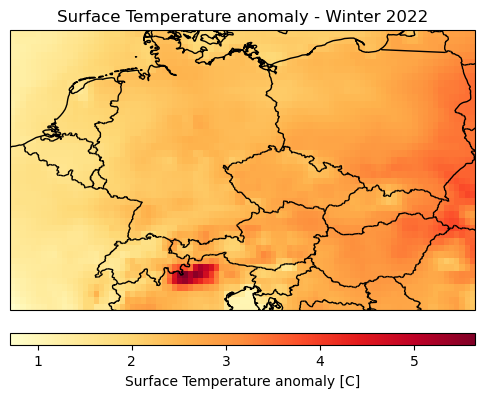

In [6]:
from cartopy import crs, feature
import matplotlib.pyplot as plt

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
t2m_anomaly_central_europe_winter_2022_mean.plot(
    ax=ax, 
    cmap="YlOrRd", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Surface Temperature anomaly [C]"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("Surface Temperature anomaly - Winter 2022")
plt.show()

## 2 metre temperature: central Europe winter anomaly trend (spatial mean)

We want to compute the average 2 metre temperature anomaly trend over Central Europe in winter. We already have `t2m_anomaly_central_europe` loaded in memory, we average it by seson and region:

In [7]:
t2m_anomaly_central_europe_seasonal_and_spatial_mean = t2m_anomaly_central_europe.resample(time="QS-DEC").mean(dim=["time", "latitude", "longitude"])
t2m_anomaly_central_europe_seasonal_and_spatial_mean

<xarray.DataArray 't2m' (time: 179)>
array([-2.060959  , -0.45316032, -1.5052906 ,  0.15483867, -1.2419376 ,
       -2.0460992 , -1.1296408 , -1.0432692 , -0.3133328 , -0.40941787,
       -0.68241465, -0.96041375, -1.158114  , -0.7384622 ,  0.6626135 ,
        0.86394155,  0.5391145 , -0.04454695,  0.658656  , -0.5829343 ,
       -0.7674438 , -1.5542306 , -1.2261734 ,  0.38303712, -3.8773434 ,
       -0.9083585 , -0.5325631 , -0.37815017, -2.5465033 , -0.13529216,
       -1.1898304 ,  0.29763573, -3.844396  , -1.3422297 , -0.49450874,
        0.4939549 ,  0.89289874, -0.19609773, -0.30868402, -0.3769552 ,
        2.2923522 , -0.26558912, -0.06340466,  0.19422808,  3.0285063 ,
       -0.16238637, -0.8706532 ,  0.1259329 , -0.1930461 , -2.1154659 ,
        0.5931147 , -0.8084522 ,  0.7189054 ,  0.27479738,  0.7535636 ,
       -0.59424114, -0.2840044 ,  0.7270577 , -1.3418669 , -0.8755802 ,
        1.3126562 , -0.29825318,  1.2617062 ,  0.831811  ,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.7249287 ,  0.3585273 ,  1.0583944 , -0.22196446,  1.0320425 ,
        1.5091852 , -0.5830848 ,  1.961222  ,  0.93315333, -0.3289366 ,
       -0.03018923, -0.17068556,  2.0469658 ,  0.93966997,  0.33949322,
       -0.1183575 , -1.0529342 ,  1.4598475 ,  1.3155189 , -0.08185413,
       -0.09058002, -0.2972214 ,  0.05204505,  0.6677273 , -0.6966607 ,
        0.374496  ,  0.11622899,  0.2791322 , -2.1575992 ,  0.3797368 ,
        1.4776993 ,  2.5945342 ,  3.0873117 ,  1.9201499 , -0.34579396,
       -0.48396856,  2.006877  ,  0.7420931 , -0.22089075,  0.6773413 ,
       -0.49495363,  1.0849769 ,  0.9993198 ,  0.51327455, -1.3782848 ,
       -0.04597156,  0.33619487, -1.3149176 ,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        1.842588  ,  1.2035154 ,  1.1523886 ,  2.1609879 ,  2.7206538 ,
        0.6640334 ,  1.249677  ,  1.6033627 ,  0.6236197 , -0.22357346,
        0.62067425,  0.6341066 ,  1.9439217 ,  1.1460983 ,  1.2255656 ,
        1.9805168 ,  2.4085422 ,  0.56737703,  2.0665157 ], dtype=float32)
Coordinates:
    depthBelowLandLayer  float64 0.0
    number               int64 0
    step                 timedelta64[ns] 12 days
    surface              float64 0.0
  * time                 (time) datetime64[ns] 1978-12-01 ... 2023-06-01
Attributes: (12/30)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

Next, we select only the winter values:

In [8]:
t2m_anomaly_central_europe_winter_spatial_mean = t2m_anomaly_central_europe_seasonal_and_spatial_mean.sel(time=t2m_anomaly_central_europe_seasonal_and_spatial_mean["time.month"] == int(12))

We can plot the result:

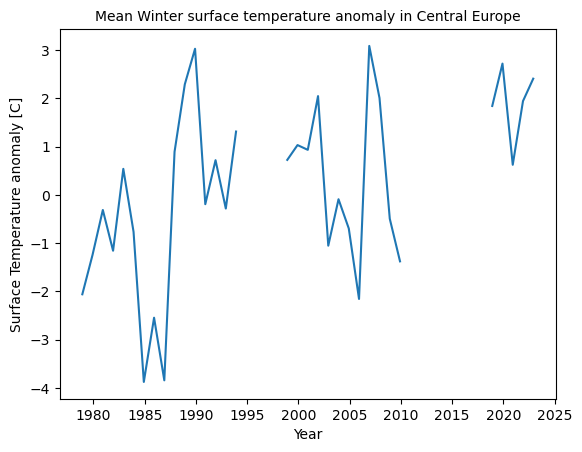

In [10]:
plt.plot(t2m_anomaly_central_europe_winter_spatial_mean["time"], t2m_anomaly_central_europe_winter_spatial_mean)
plt.xlabel("Year")
plt.ylabel("Surface Temperature anomaly [C]")
plt.title("Mean Winter surface temperature anomaly in Central Europe", size=10)
plt.show()